### DSE-230 Final Project
## Diabetes Risk Prediction from Personal Health Indicators
### Notebook 1: Project Description and EDA
***
#### Chunxia Tong  
#### Camm Perera
#### Sergey Gurvich

***
## Table of Contents:

* [1. Project Description and Setup](#project_description)
    * [1.1 Problem Description](#problem_description)
    * [1.2 Success Criteria](#success_criteria)
    * [1.3 Links](#links)
    * [1.4 Project Setup](#setup)
* [2. EDA](#eda)
    * [2.1 Dataset Dimensions and Schema](#eda)
    * [2.2 Missing Values](#missing_values_eda)
    * [2.3 Summary Statistics](#summary_statistics)
    * [2.4 Visualizations](#visualizations)
* [3. Stop Spark Session](#stop)
***

## 1. Project Description and Setup <a class="anchor" id="project_description"></a>

### 1.1 Problem Description <a class="anchor" id="problem_description"></a>
**Background:** 37.3 million US adults have diabetes, and 1 in 5 of them don’t know they have it. Diabetes is the seventh leading cause of death in the United States.  
**Dataset:** the Behavioral Risk Factor Surveillance System (BRFSS) is the nation’s premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services.  
**Applications:** healthcare and/or insurance industries.  
**Problem:** based on personal health indicators, predict if a person is at risk of developing the diabetes disease.  

### 1.2 Success Criteria <a class="anchor" id="success_criteria"></a>
Build a binary classification model that can make a prediction with 85% accuracy rate.

### 1.3 Links <a class="anchor" id="links"></a>
Project files in GIT: https://github.com/spring-camm-sergey/dse230  
Original dataset files and description: https://www.cdc.gov/brfss/annual_data/annual_2020.html


### 1.4 Project Setup <a class="anchor" id="setup"></a>
Please read Readme file located in https://github.com/spring-camm-sergey/dse230/blob/main/README.txt

_Note: for running locally, please place the CSV files into HDFS. Example:_
```
hadoop fs -copyFromLocal work/project/BRFSS_2020_main_dataset.csv /;
hadoop fs -copyFromLocal work/project/Behavioral_Risk_Factor_Surveillance_System__BRFSS__Historical_Questions.csv /;
hadoop fs -copyFromLocal work/project/BRFSS_feature_codes_map.csv /;
```

#### 1.4.1 Imports

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pyspark
import numpy as np  # for histogram plot
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, abs
from pyspark.sql.types import FloatType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

#### 1.4.2 Start Spark Session <a class="anchor" id="start_spark_session"></a>

In [2]:
conf = pyspark.SparkConf().setAll([('spark.master', 'local[*]'),
                                   ('spark.app.name', 'Basic Setup'),
                                    ('spark.memory.offHeap.enabled', True),
                                    ('spark.memory.offHeap.size','8g'),
                                    ('spark.executor.memory', '16g'), 
                                    ('spark.driver.memory','16g')
                                  ]
                                  )
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.sparkContext.setLogLevel('OFF')
spark.version

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-30 23:54:03,675 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


'3.2.1'

#### 1.4.3 Read Data <a class="anchor" id="read_data"></a>

In [3]:
# main dataset
orig_df = spark.read.option("header", True).csv('hdfs:///BRFSS_2020_main_dataset.csv', inferSchema=True)

## 2. EDA <a class="anchor" id="eda"></a>

### 2.1 Dataset Dimensions and Schema

In [4]:
orig_sdf  = orig_df
print(f"Number of samples: {orig_sdf.count()}")
print(f"Number of features: {len(orig_sdf.columns)}")

Number of samples: 401958
Number of features: 279


In [5]:
orig_sdf.printSchema()

root
 |-- _STATE: integer (nullable = true)
 |-- FMONTH: integer (nullable = true)
 |-- IDATE: integer (nullable = true)
 |-- IMONTH: integer (nullable = true)
 |-- IDAY: integer (nullable = true)
 |-- IYEAR: integer (nullable = true)
 |-- DISPCODE: integer (nullable = true)
 |-- SEQNO: integer (nullable = true)
 |-- _PSU: integer (nullable = true)
 |-- CTELENM1: integer (nullable = true)
 |-- PVTRESD1: integer (nullable = true)
 |-- COLGHOUS: integer (nullable = true)
 |-- STATERE1: integer (nullable = true)
 |-- CELPHONE: integer (nullable = true)
 |-- LADULT1: integer (nullable = true)
 |-- COLGSEX: integer (nullable = true)
 |-- NUMADULT: integer (nullable = true)
 |-- LANDSEX: integer (nullable = true)
 |-- NUMMEN: integer (nullable = true)
 |-- NUMWOMEN: integer (nullable = true)
 |-- RESPSLCT: integer (nullable = true)
 |-- SAFETIME: integer (nullable = true)
 |-- CTELNUM1: integer (nullable = true)
 |-- CELLFON5: integer (nullable = true)
 |-- CADULT1: integer (nullable = true)

### 2.2 Missing Values <a class="anchor" id="missing_values_eda"></a>

##### To preserve non-sparse samples, we removed columns that do not meet the threshhold: they must have at least 300k NOT NULLs:

In [6]:
# Note: this code was taken and modified per our needs from:
# https://stackoverflow.com/questions/51322445/how-to-drop-all-columns-with-null-values-in-a-pyspark-dataframe

def drop_null_columns(sdf, threshold=0):
    """
    Drops all columns which contain null values. 
    Leave columns, where count(not nulls) > threshhold.
    Note: Simulates pandas.DataFrame.dropna(axis=1, thresh=300000)
    
    :param Dataframe sdf: PySpark DataFrame to work with
    :param int threshold: min numbers of not nulls in column in order not to drop it
    :return: cleaned PySpark dataFrame
    """
    null_counts = sdf.select([count(when(
        col(c).isNull() | 
        col(c).contains('None') | 
        col(c).contains('NULL') | 
        col(c).contains('NA') | 
        (col(c)=='') | 
        (col(c)==99) | 
        isnan(c), 
        c)).alias(c) for c in sdf.columns]).collect()[0].asDict()
    
    to_drop = [k for k, v in null_counts.items() if v > sdf.count()-threshold]
    sdf = sdf.drop(*to_drop)
    return sdf



data_sdf = drop_null_columns(orig_sdf, threshold=300000)


print(f'Original number of samples: {orig_sdf.count()}, , number of columns: {len(orig_sdf.columns)}')
print(f'Cleaned number of samples: {data_sdf.count()}, , number of columns: {len(data_sdf.columns)}')

Original number of samples: 401958, , number of columns: 279
Cleaned number of samples: 401958, , number of columns: 112


##### Remove NULL samples:

In [7]:
cleaned_sdf = data_sdf.na.drop()
print(f'Cleaned number of samples: {cleaned_sdf.count()}, and number of features: {len(cleaned_sdf.columns)}')

Cleaned number of samples: 326959, and number of features: 112


### 2.3 Summary Statistics <a class="anchor" id="summary_statistics"></a>

In [8]:
# Note: this code is likely to throw memory heap Java error, so it might be temporarily commented out.
# this is to skip execution of a cell:

# summary_sdf = cleaned_sdf.summary()
# summary_sdf.count(), len(summary_sdf.columns)

In [9]:
#--- Summary Stats Transpose Code ---
def transpose_df(df, columns, pivot_col):
    """
    The function transposes the summary stats dataframe.
    Source: https://nikhil-suthar-bigdata.medium.com/how-to-transpose-spark-dataframe-fa82c079a6b
  
    :param DataFrame df - summary stats dataframe
    :param list columns: - columns list
    :param str pivot_col - pivot column name
    :return: None
    """
    columns_value = list(map(lambda x: str("'") + str(x) + str("',")  + str(x), columns))
    stack_cols = ','.join(x for x in columns_value)
    df_1 = df.selectExpr(pivot_col, "stack(" + str(len(columns)) + "," + stack_cols + ")")\
           .select(pivot_col, "col0", "col1")
    final_df = df_1.groupBy(col("col0")).pivot(pivot_col).agg(concat_ws("", collect_list(col("col1"))))\
                 .withColumnRenamed("col0", pivot_col)
    return final_df

# Note: this code is likely to throw memory heap Java error, so it might be temporarily commented out.
# this is to skip execution of a cell:

# summary_trans_sdf = transpose_df(summary_sdf, summary_sdf.columns[1:], 'summary')
# summary_trans_sdf.show(115)

### 2.4 Visualizations <a class="anchor" id="visualizations"></a>

#### 2.4.1 Feature Correlations and the Heatmap

In [10]:
# Get absolute corrrelation coefficients for DIABETE4 (target) feature

corr_cols = [x for x in cleaned_sdf.columns]
corr_list = []

for col in range(len(corr_cols)):
    corr_list.append({"feature": corr_cols[col] , "correlation": cleaned_sdf.stat.corr('DIABETE4',corr_cols[col])})
    
corr_sdf = spark.createDataFrame(corr_list)
corr_abs_sdf = corr_sdf.withColumn('corr_absolute', abs(corr_sdf["correlation"]))
corr_filtered_sdf = corr_abs_sdf.filter(corr_abs_sdf.corr_absolute > 0.1)

corr_filtered_sdf[['feature', 'corr_absolute']].sort(corr_filtered_sdf.corr_absolute.desc()).show(30)

+--------+-------------------+
| feature|      corr_absolute|
+--------+-------------------+
|DIABETE4|                1.0|
| GENHLTH|0.24340324217549966|
|  _AGE_G|0.18566104340993733|
|   _BMI5|0.18564263474273196|
|  _AGE80|0.18480478597113167|
|_AGEG5YR|0.17934966268845232|
|_BMI5CAT| 0.1678549836616008|
|  _MICHD|0.16777848687506502|
| EMPLOY1|0.16395298848008066|
| _RFHLTH| 0.1583593772232029|
|   WTKG3|0.15146909226095578|
|DIFFWALK|0.14561578202781555|
|_DRDXAR2| 0.1442233091718822|
|HAVARTH4|0.14422330917188217|
|_HCVU651|0.13845058824181006|
|_AGE65YR|0.13344457583732638|
| _RFBMI5|0.12951355502292466|
|_DRNKDRV| 0.1280952455367749|
| ALCDAY5|0.12657147533039714|
|RMVTETH4| 0.1258997627902426|
|EXERANY2|0.11521070755157531|
|CVDINFR4|0.11420407874965832|
|_TOTINDA|0.10979460176323247|
|CHECKUP1|0.10747923192999646|
|PNEUVAC4|0.10083168617775363|
+--------+-------------------+



In [11]:
# This cell is to print the reduced heatmap, only for the presentation purpose.

# Remove some features for concise heatmap visual:
features_to_remove = (
# 'CHECKUP1', #'LENGTH OF TIME SINCE LAST ROUTINE CHECKUP'
# 'CVDINFR4', #'EVER DIAGNOSED WITH HEART ATTACK'
# 'RMVTETH4', #'NUMBER OF PERMANENT TEETH REMOVED',
# 'PNEUVAC4', #'PNEUMONIA SHOT EVER', 
# '_RFHLTH',  #'ADULTS WITH GOOD OR BETTER HEALTH',
# '_TOTINDA', #'LEISURE TIME PHYSICAL ACTIVITY CALCULATED VARIABLE',
# '_AGE65YR', #'REPORTED AGE IN TWo AGE GROUPS CALCULATED VARIABLE',
# '_AGE80',   #'IMPUTED AGE VALUE COLLAPSED ABOVE 80',
# '_AGE_G',   #'IMPUTED AGE IN SIX GROUPS',
# '_RFBMI5',  #'OVERWEIGHT OR OBESE CALCULATED VARIABLE',
# '_DRNKDRV'  #'DRINKING AND DRIVING'
)

# Get correlation feature names 
corr_features = [row[0] for row in corr_filtered_sdf.select('Feature').collect()]

corr_features_sdf = cleaned_sdf.select(corr_features)
corr_features_reduced_sdf = corr_features_sdf.drop(*features_to_remove)
corr_features_reduced_sdf.printSchema()

root
 |-- GENHLTH: integer (nullable = true)
 |-- CHECKUP1: integer (nullable = true)
 |-- EXERANY2: integer (nullable = true)
 |-- CVDINFR4: integer (nullable = true)
 |-- HAVARTH4: integer (nullable = true)
 |-- DIABETE4: integer (nullable = true)
 |-- RMVTETH4: integer (nullable = true)
 |-- EMPLOY1: integer (nullable = true)
 |-- DIFFWALK: integer (nullable = true)
 |-- ALCDAY5: integer (nullable = true)
 |-- PNEUVAC4: integer (nullable = true)
 |-- _RFHLTH: integer (nullable = true)
 |-- _HCVU651: integer (nullable = true)
 |-- _TOTINDA: integer (nullable = true)
 |-- _MICHD: integer (nullable = true)
 |-- _DRDXAR2: integer (nullable = true)
 |-- _AGEG5YR: integer (nullable = true)
 |-- _AGE65YR: integer (nullable = true)
 |-- _AGE80: integer (nullable = true)
 |-- _AGE_G: integer (nullable = true)
 |-- WTKG3: integer (nullable = true)
 |-- _BMI5: integer (nullable = true)
 |-- _BMI5CAT: integer (nullable = true)
 |-- _RFBMI5: integer (nullable = true)
 |-- _DRNKDRV: integer (null

In [12]:
#  Build correlation matrix
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=corr_features_reduced_sdf.columns, 
                            outputCol=vector_col)
heatmap_vector = assembler.transform(corr_features_reduced_sdf).select(vector_col)
matrix = Correlation.corr(heatmap_vector, vector_col)

matrix = Correlation.corr(heatmap_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
heatmap_sdf = spark.createDataFrame(corrmatrix, corr_features_reduced_sdf.columns, corr_features_reduced_sdf.columns)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


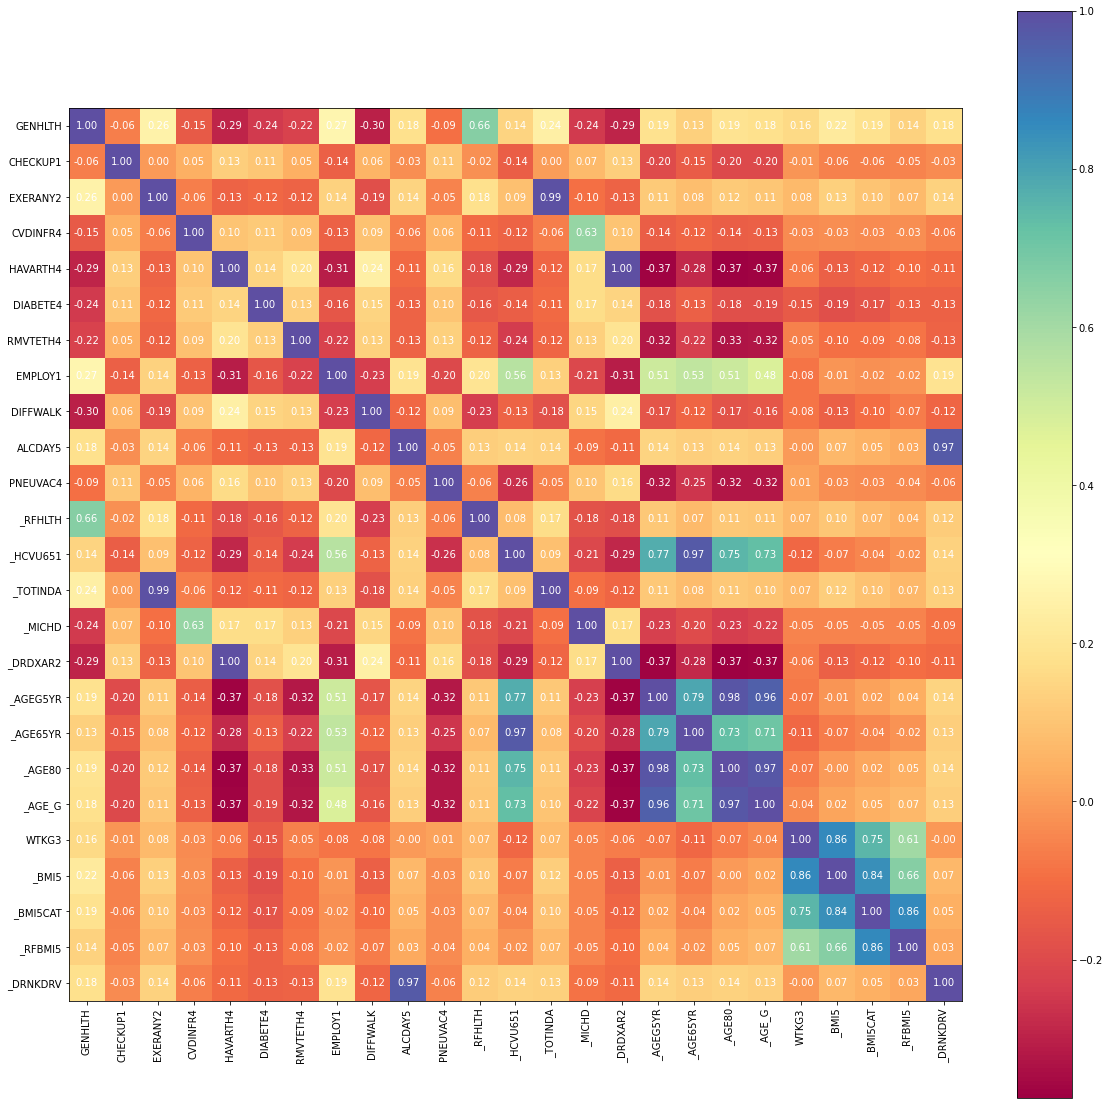

In [13]:
# Plot correaltion heatmap
plt.imshow(corrmatrix, cmap='Spectral')
plt.colorbar()
plt.xticks(range(len(heatmap_sdf.columns)), heatmap_sdf.columns, rotation=90)
plt.yticks(range(len(heatmap_sdf.columns)), heatmap_sdf.columns)
plt.gcf().set_size_inches(20,20)

labels = np.array(heatmap_sdf.collect())

for y in range(labels.shape[0]):
    for x in range(labels.shape[1]):
        plt.text(x, y, '{:.2f}' .format(labels[y, x]), ha='center', va='center', color='white')

#### 2.4.2 Sex of Respondent: the Pie Chart

In [14]:
# Exclude age group 14='No response'
age_not_grp14_sdf = cleaned_sdf.filter(cleaned_sdf['_AGEG5YR'] < 14)
pie_sdf = age_not_grp14_sdf.select('SEXVAR')

In [15]:
# Get group counts for repondent sex
pie_group_sdf = pie_sdf.groupBy('SEXVAR').count().orderBy('count', ascending=True)
pie_group_renamed_sdf = pie_group_sdf.withColumnRenamed('count', 'pop_count')
pie_group_count = pie_group_renamed_sdf.collect()

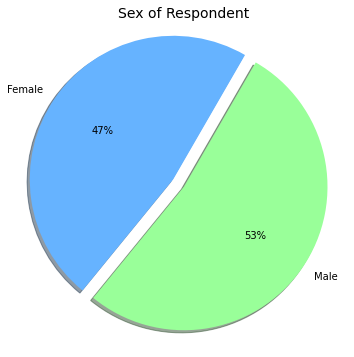

In [16]:
# Pie data prep
pie_data = []

for i in range(len(pie_group_count)):
    pie_data.append(pie_group_count[i].pop_count)

#define color palette to use
colors = ['#66b3ff','#99ff99','#ffcc99','#ff9999']

# define data labels
labels = ['Female', 'Male']

# Create a pieplot
plt.figure(figsize=(6, 6))
plt.pie(pie_data, labels=labels, colors=colors, autopct='%.00f%%' ,radius=1.1 ,shadow=True, explode=[0.1,0], startangle=60)
plt.title("Sex of Respondent", fontdict={'fontsize':14})
plt.show()

#### 2.4.3 Computed Body Mass Index: the Histogram

In [17]:
# Remove outliers (too high BMI)
histo_sdf = cleaned_sdf.filter(cleaned_sdf._BMI5 < 6000)
histo_bmi_vals = histo_sdf.select('_BMI5').collect()

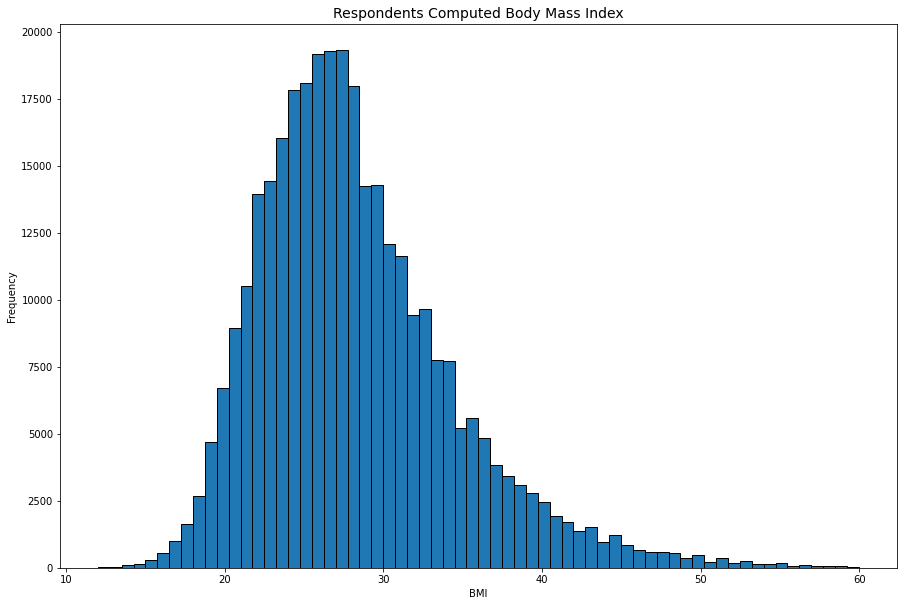

In [18]:
# Histo data prep
hsito_data = []

for i in range(len(histo_bmi_vals)):
    hsito_data.append(histo_bmi_vals[i]._BMI5/100)

hsito_data[:5]

# Plot histogram
counts, bins = np.histogram(hsito_data, bins=64)
plt.figure(figsize=(15, 10))
plt.hist(bins[:-1], bins, weights=counts, ec='black')
plt.title('Respondents Computed Body Mass Index', fontdict={'fontsize':14})
plt.ylabel('Frequency')
plt.xlabel('BMI')
plt.show()

## 3. Stop Spark Session: <a class="anchor" id="stop"></a>

In [19]:
spark.stop()